Epoch [1/30], Train Loss: 2.3269, Train Accuracy: 14.89%, Val Loss: 2.1773, Val Accuracy: 37.11%
Epoch [2/30], Train Loss: 2.0284, Train Accuracy: 33.69%, Val Loss: 1.9194, Val Accuracy: 39.18%
Epoch [3/30], Train Loss: 1.7887, Train Accuracy: 48.94%, Val Loss: 1.6242, Val Accuracy: 46.39%
Epoch [4/30], Train Loss: 1.5360, Train Accuracy: 64.18%, Val Loss: 1.4275, Val Accuracy: 71.13%
Epoch [5/30], Train Loss: 1.3546, Train Accuracy: 69.86%, Val Loss: 1.2916, Val Accuracy: 76.29%
Epoch [6/30], Train Loss: 1.2810, Train Accuracy: 67.38%, Val Loss: 1.2047, Val Accuracy: 69.07%
Epoch [7/30], Train Loss: 1.1458, Train Accuracy: 71.28%, Val Loss: 1.1106, Val Accuracy: 77.32%
Epoch [8/30], Train Loss: 1.1038, Train Accuracy: 71.99%, Val Loss: 1.0436, Val Accuracy: 75.26%
Epoch [9/30], Train Loss: 1.0411, Train Accuracy: 74.82%, Val Loss: 0.9791, Val Accuracy: 78.35%
Epoch [10/30], Train Loss: 0.9640, Train Accuracy: 79.43%, Val Loss: 0.8880, Val Accuracy: 84.54%
Epoch [11/30], Train Loss: 0.

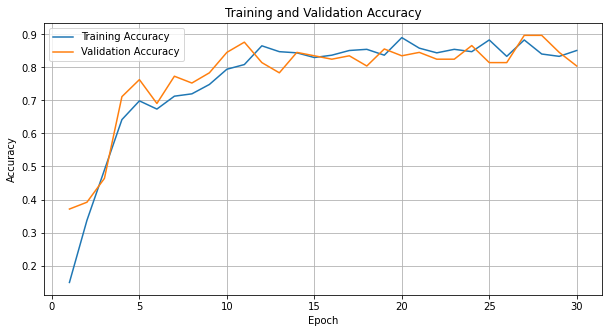

In [7]:
#With Old Dataset

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet50
import matplotlib.pyplot as plt

# Define paths to the criminal face dataset
criminal_train_path = 'C:/crowdcrime/yolov8-streamlit-detection-tracking/face/aligned_faces/train'
criminal_val_path = 'C:/crowdcrime/yolov8-streamlit-detection-tracking/face/aligned_faces/val'
criminal_test_path = 'C:/crowdcrime/yolov8-streamlit-detection-tracking/face/aligned_faces/test'

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing for ResNet50 input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Add random rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Add color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Mean and std for ResNet50
])

# Load criminal face datasets
criminal_train_dataset = ImageFolder(root=criminal_train_path, transform=transform)
criminal_val_dataset = ImageFolder(root=criminal_val_path, transform=transform)
criminal_test_dataset = ImageFolder(root=criminal_test_path, transform=transform)

# Define data loaders for training, validation, and testing sets
batch_size = 32
criminal_train_loader = DataLoader(criminal_train_dataset, batch_size=batch_size, shuffle=True)
criminal_val_loader = DataLoader(criminal_val_dataset, batch_size=batch_size)
criminal_test_loader = DataLoader(criminal_test_dataset, batch_size=batch_size)

# Define face recognition model
class ResNetRecognizer(nn.Module):
    def __init__(self, num_classes):
        super(ResNetRecognizer, self).__init__()
        self.resnet = resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

# Initialize the ResNetRecognizer model with the number of classes in the custom dataset
num_classes_custom = len(criminal_train_dataset.classes)
model_custom = ResNetRecognizer(num_classes_custom)

# Define loss function and optimizer for custom dataset
criterion_custom = nn.CrossEntropyLoss()
optimizer_custom = optim.Adam(model_custom.parameters(), lr=0.001)  # Adjust learning rate

# Define learning rate scheduler
scheduler = StepLR(optimizer_custom, step_size=10, gamma=0.1)

# Define early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
counter = 0

# Lists to store accuracy values
train_accuracy_list = []
val_accuracy_list = []

# Training loop for custom dataset with early stopping
num_epochs_custom = 30  # Increase the number of epochs
for epoch in range(num_epochs_custom):
    # Training
    model_custom.train()
    train_loss_custom = 0.0
    correct_custom = 0
    total_custom = 0
    for images, labels in criminal_train_loader:
        optimizer_custom.zero_grad()
        outputs = model_custom(images)
        loss = criterion_custom(outputs, labels)
        loss.backward()
        optimizer_custom.step()
        train_loss_custom += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_custom += labels.size(0)
        correct_custom += (predicted == labels).sum().item()
    train_loss_custom /= len(criminal_train_loader.dataset)
    train_accuracy_custom = correct_custom / total_custom

    # Validation
    model_custom.eval()
    val_loss_custom = 0.0
    correct_custom = 0
    total_custom = 0
    with torch.no_grad():
        for images, labels in criminal_val_loader:
            outputs = model_custom(images)
            loss = criterion_custom(outputs, labels)
            val_loss_custom += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_custom += labels.size(0)
            correct_custom += (predicted == labels).sum().item()
        val_loss_custom /= len(criminal_val_loader.dataset)
        val_accuracy_custom = correct_custom / total_custom
        
    # Append accuracy values to the lists
    train_accuracy_list.append(train_accuracy_custom)
    val_accuracy_list.append(val_accuracy_custom)

    # Update learning rate scheduler
    scheduler.step()

    # Check for early stopping
    #if val_loss_custom < best_val_loss:
       # best_val_loss = val_loss_custom
        #counter = 0  # Reset patience counter
    #else:
     #   counter += 1

    # Print training progress
    print(f'Epoch [{epoch+1}/{num_epochs_custom}], '
          f'Train Loss: {train_loss_custom:.4f}, '
          f'Train Accuracy: {train_accuracy_custom:.2%}, '
          f'Val Loss: {val_loss_custom:.4f}, '
          f'Val Accuracy: {val_accuracy_custom:.2%}')

    # Check if early stopping criteria met
    #if counter >= patience:
       # print("Early stopping triggered!")
        # break  # Stop training loop

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracy_list) + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_list) + 1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Save the trained model
torch.save(model_custom.state_dict(), 'criminal_face_detection_resnetnewmodel.pth')


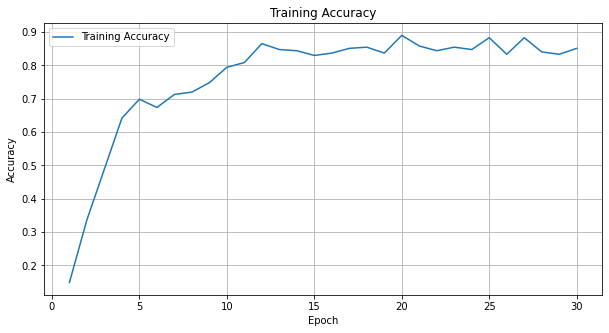

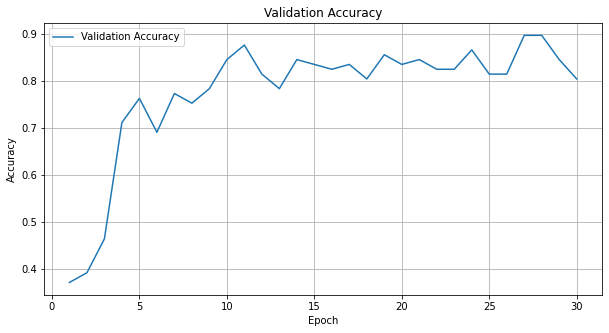

In [8]:
# Plotting the training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracy_list) + 1), train_accuracy_list, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracy_list) + 1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Define testing loop for custom dataset
model_custom.eval()
test_loss_custom = 0.0
correct_custom = 0
total_custom = 0
with torch.no_grad():
    for images, labels in criminal_test_loader:
        outputs = model_custom(images)
        loss = criterion_custom(outputs, labels)
        test_loss_custom += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_custom += labels.size(0)
        correct_custom += (predicted == labels).sum().item()
test_loss_custom /= len(criminal_test_loader.dataset)
test_accuracy_custom = correct_custom / total_custom

print(f'Test Loss on Custom Dataset: {test_loss_custom:.4f}')
print(f'Test Accuracy on Custom Dataset: {test_accuracy_custom:.2%}')

Test Loss on Custom Dataset: 0.7778
Test Accuracy on Custom Dataset: 83.17%


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Get the predicted labels and true labels
predicted_labels = predicted.cpu().numpy()
true_labels = labels.cpu().numpy()

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[0 0]
 [2 3]]


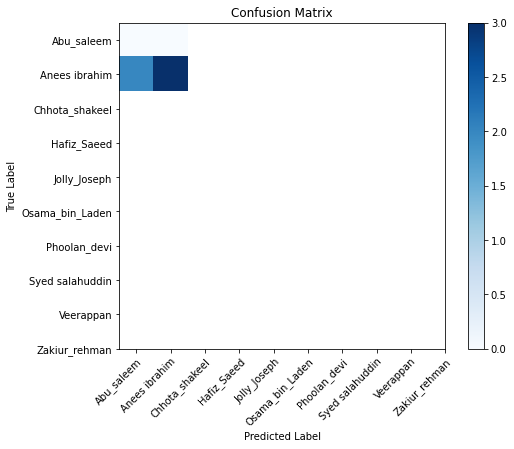

In [11]:
# Define the class labels
class_labels = criminal_test_dataset.classes

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix as a heatmap
im = ax.imshow(conf_matrix, cmap='Blues')

# Set the x and y ticks
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Rotate the x-tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add labels and title
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()

New Dataset

C:\Users\vanam\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vanam\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Train Loss: 2.4143, Train Accuracy: 12.26%, Val Loss: 2.1988, Val Accuracy: 25.88%
Epoch [2/30], Train Loss: 2.1657, Train Accuracy: 20.69%, Val Loss: 1.8313, Val Accuracy: 36.47%
Epoch [3/30], Train Loss: 1.8938, Train Accuracy: 35.63%, Val Loss: 1.6254, Val Accuracy: 60.00%
Epoch [4/30], Train Loss: 1.7669, Train Accuracy: 45.59%, Val Loss: 1.5156, Val Accuracy: 61.18%
Epoch [5/30], Train Loss: 1.6232, Train Accuracy: 50.57%, Val Loss: 1.3075, Val Accuracy: 78.82%
Epoch [6/30], Train Loss: 1.4156, Train Accuracy: 65.52%, Val Loss: 1.2783, Val Accuracy: 72.94%
Epoch [7/30], Train Loss: 1.3273, Train Accuracy: 68.97%, Val Loss: 1.1934, Val Accuracy: 78.82%
Epoch [8/30], Train Loss: 1.2157, Train Accuracy: 71.65%, Val Loss: 0.9901, Val Accuracy: 81.18%
Epoch [9/30], Train Loss: 1.1520, Train Accuracy: 72.80%, Val Loss: 1.0552, Val Accuracy: 74.12%
Epoch [10/30], Train Loss: 1.1605, Train Accuracy: 70.88%, Val Loss: 0.9764, Val Accuracy: 82.35%
Epoch [11/30], Train Loss: 1.

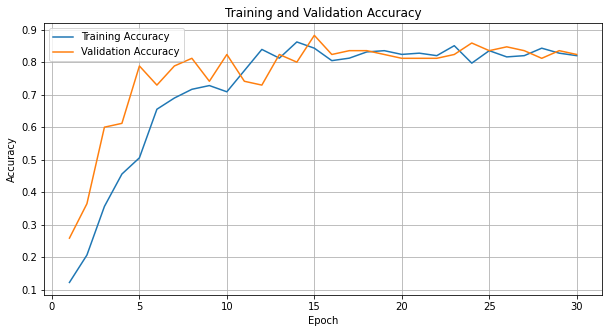

In [1]:
#With Old Dataset

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet50
import matplotlib.pyplot as plt

# Define paths to the criminal face dataset
criminal_train_path = 'C:/crowdcrime/yolov8-streamlit-detection-tracking/face/aligned_faces/train'
criminal_val_path = 'C:/crowdcrime/yolov8-streamlit-detection-tracking/face/aligned_faces/val'
criminal_test_path = 'C:/crowdcrime/yolov8-streamlit-detection-tracking/face/aligned_faces/test'

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing for ResNet50 input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Add random rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Add color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Mean and std for ResNet50
])

# Load criminal face datasets
criminal_train_dataset = ImageFolder(root=criminal_train_path, transform=transform)
criminal_val_dataset = ImageFolder(root=criminal_val_path, transform=transform)
criminal_test_dataset = ImageFolder(root=criminal_test_path, transform=transform)

# Define data loaders for training, validation, and testing sets
batch_size = 32
criminal_train_loader = DataLoader(criminal_train_dataset, batch_size=batch_size, shuffle=True)
criminal_val_loader = DataLoader(criminal_val_dataset, batch_size=batch_size)
criminal_test_loader = DataLoader(criminal_test_dataset, batch_size=batch_size)

# Define face recognition model
class ResNetRecognizer(nn.Module):
    def __init__(self, num_classes):
        super(ResNetRecognizer, self).__init__()
        self.resnet = resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

# Initialize the ResNetRecognizer model with the number of classes in the custom dataset
num_classes_custom = len(criminal_train_dataset.classes)
model_custom = ResNetRecognizer(num_classes_custom)

# Define loss function and optimizer for custom dataset
criterion_custom = nn.CrossEntropyLoss()
optimizer_custom = optim.Adam(model_custom.parameters(), lr=0.001)  # Adjust learning rate

# Define learning rate scheduler
scheduler = StepLR(optimizer_custom, step_size=10, gamma=0.1)

# Define early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
counter = 0

# Lists to store accuracy values
train_accuracy_list = []
val_accuracy_list = []

# Training loop for custom dataset with early stopping
num_epochs_custom = 30  # Increase the number of epochs
for epoch in range(num_epochs_custom):
    # Training
    model_custom.train()
    train_loss_custom = 0.0
    correct_custom = 0
    total_custom = 0
    for images, labels in criminal_train_loader:
        optimizer_custom.zero_grad()
        outputs = model_custom(images)
        loss = criterion_custom(outputs, labels)
        loss.backward()
        optimizer_custom.step()
        train_loss_custom += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_custom += labels.size(0)
        correct_custom += (predicted == labels).sum().item()
    train_loss_custom /= len(criminal_train_loader.dataset)
    train_accuracy_custom = correct_custom / total_custom

    # Validation
    model_custom.eval()
    val_loss_custom = 0.0
    correct_custom = 0
    total_custom = 0
    with torch.no_grad():
        for images, labels in criminal_val_loader:
            outputs = model_custom(images)
            loss = criterion_custom(outputs, labels)
            val_loss_custom += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_custom += labels.size(0)
            correct_custom += (predicted == labels).sum().item()
        val_loss_custom /= len(criminal_val_loader.dataset)
        val_accuracy_custom = correct_custom / total_custom
        
    # Append accuracy values to the lists
    train_accuracy_list.append(train_accuracy_custom)
    val_accuracy_list.append(val_accuracy_custom)

    # Update learning rate scheduler
    scheduler.step()

    # Check for early stopping
    #if val_loss_custom < best_val_loss:
       # best_val_loss = val_loss_custom
        #counter = 0  # Reset patience counter
    #else:
     #   counter += 1

    # Print training progress
    print(f'Epoch [{epoch+1}/{num_epochs_custom}], '
          f'Train Loss: {train_loss_custom:.4f}, '
          f'Train Accuracy: {train_accuracy_custom:.2%}, '
          f'Val Loss: {val_loss_custom:.4f}, '
          f'Val Accuracy: {val_accuracy_custom:.2%}')

    # Check if early stopping criteria met
    #if counter >= patience:
       # print("Early stopping triggered!")
        # break  # Stop training loop

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracy_list) + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_list) + 1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Save the trained model
torch.save(model_custom.state_dict(), 'criminal_face_detection_resnetmodel.pth')

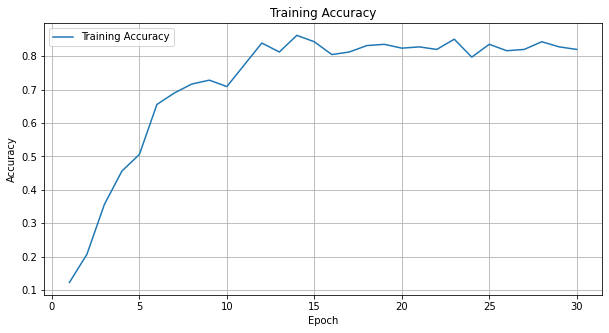

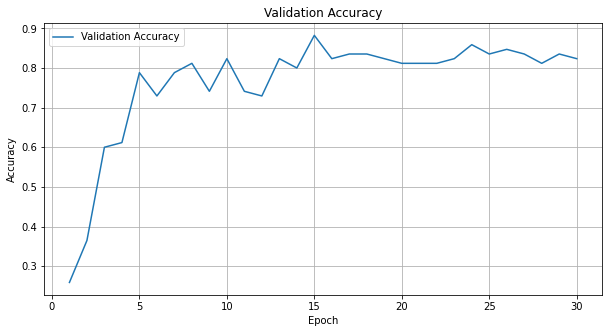

In [2]:
# Plotting the training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracy_list) + 1), train_accuracy_list, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracy_list) + 1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
# Define testing loop for custom dataset
model_custom.eval()
test_loss_custom = 0.0
correct_custom = 0
total_custom = 0
with torch.no_grad():
    for images, labels in criminal_test_loader:
        outputs = model_custom(images)
        loss = criterion_custom(outputs, labels)
        test_loss_custom += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_custom += labels.size(0)
        correct_custom += (predicted == labels).sum().item()
test_loss_custom /= len(criminal_test_loader.dataset)
test_accuracy_custom = correct_custom / total_custom

print(f'Test Loss on Custom Dataset: {test_loss_custom:.4f}')
print(f'Test Accuracy on Custom Dataset: {test_accuracy_custom:.2%}')

Test Loss on Custom Dataset: 0.9594
Test Accuracy on Custom Dataset: 79.55%


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Get the predicted labels and true labels
predicted_labels = predicted.cpu().numpy()
true_labels = labels.cpu().numpy()

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 1  1  9  0]
 [ 0  0  2 11]]


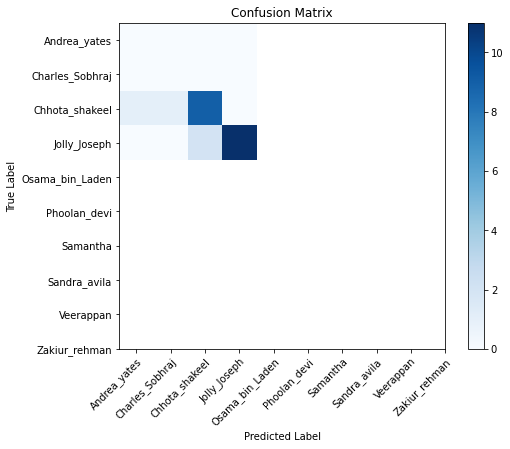

In [5]:
# Define the class labels
class_labels = criminal_test_dataset.classes

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix as a heatmap
im = ax.imshow(conf_matrix, cmap='Blues')

# Set the x and y ticks
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Rotate the x-tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add labels and title
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()